# Tarea 2: Backpropagation, descenso de gradiente y entrenamiento <br/> CC6204 Deep Learning, Universidad de Chile 



In [1]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch 
import torch

# Parte 1: Preliminares: funciones de activación y función de error

## 1a) Derivando las funciones de activación

En esta parte se calculan e implementan las derivadas de las funciones `relu`, `swish` y `celu`. `swish` y `celu` tienen ambas parámetros adicionales así que se calculan las derivadas (parciales) con respecto a ellos también.

In [2]:
# Más adelante en la tarea necesitaremos usar las funciones de activación 
# que implementaste en la Tarea 1 y sus derivadas.
# Acá implementa las derivadas de las funciones de activación

# Una forma de implementarlas (tal vez no la mejor) es reutilizando la misma función
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T):
  return torch.clamp(T, min=0)
  

def swish(T, beta):
  return sig(T*beta)*T

def celu(T, alfa):
  if alfa == 0:
    raise ValueError("alpha cannot be 0")
  exp = alfa * torch.true_divide(T, alfa).expm1()
  exp = torch.clamp(exp, max = 0)
  return relu(T) + exp

def softmax(T, dim, estable=True):
  if estable:
    T -= T.max(dim=dim, keepdim=True)[0]  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed
  exp = torch.exp(T)
  return exp / torch.sum(exp, dim=dim, keepdim=True)

def drelu_dx(T):
  outT = torch.clone(T) # es necesario, porque si no modificariamos el tensor de entrada
  outT=torch.clamp(outT, min=0)
  outT[outT > 0] = 1
  return outT


def dswish_dx(x,beta):
  #return swish(x,beta)*(torch.true_divide(1,x)+beta-torch.true_divide(swish(x,beta)*beta,x))
  return swish(x,beta)+sig(x)*(1-swish(x,beta))


def dswish_dbeta(x,beta):
  return swish(x,beta)*(x-1)


def dcelu_dx(x,alpha,h): 
  g1 = torch.ge(x, 0).to(x.dtype)
  g2 = torch.lt(x, 0).to(x.dtype)
  x2=torch.true_divide(h, alpha)+1

  return x2*g2+g1

def dcelu_dalpha(x,alpha,h):
  x1=torch.clamp(x,max=0)
  g=torch.ne(x1, 0).to(x1.dtype)
  r=torch.true_divide(h,alpha)-torch.true_divide(x,alpha**2)*h+torch.true_divide(x,alpha)
  return r*g

## 1b) Entropía Cruzada

Se hace una función para computar la pérdida de nuestra red, la entropía cruzada. Para dos distribuciones de probabilidad discreta $p(x)$ y $q(x)$ la entropía cruzada (cross entropy) entre $p$ y $q$ está dada por
<br>

\begin{equation}
\it{CE}(p,q)=\sum_{x}p(x)\log \bigg(\frac{1}{q(x)}\bigg)=- \sum_{x}p(x)\log q(x)
\end{equation}
<br>
donde $x$ varía sobre todos los posibles valores para los cuales la distribución está definida.

La función `CELoss` recibe tensores $Q_{ij}$ y $P_{ij}$ (de las mismas dimensiones) y calcula el promedio de las entropías cruzadas de las distribuciones $p_i$ y $q_i$ de la siguiente forma
<br>

\begin{equation}
\it{CELoss}(Q,P)=\frac{1}{N}\sum_{i}\it{CE}(p_{i}, q_{i})
\end{equation}
<br>
donde $p_i(x)=P_{ix}$, $q_i(x)=Q_{ix}$ y $N$ es el tamaño de la primera dimension de los tensores (dimension `0`). La entropía cruzada se usa como una función de error, en donde el primer argumento ($Q$) es la aproximación (distribución de probabilidad erronea) y el segundo argumento ($P$) es el valor al que nos queremos acercar (distribución de probabilidad real, o más percisamente en nuestro caso, distribución de probabilidad empírica).

En nuestra implementación se evita cualquier ocurrencia de `NaN` debido a valores en nuestras distribuciones de probabilidad excesivamente pequeños al calcular `torch.log`. El valor épsilon limitará el valor mínimo del valor original cuando `estable=True`.

In [3]:
def CELoss(Q, P, estable=True, epsilon=1e-8):
  if estable:
    Q=Q.clamp(epsilon, 1-epsilon)
  N= Q.size()[0]
  q=torch.log(Q)
  return torch.div(torch.sum(P*q),-N).item()


# Parte 2: Back propagation

En esta parte se implementa back propagation para poder actualizar los parámetros de la red neuronal implementada en la actividad 1 . La red está dada por las ecuaciones
<br>

\begin{eqnarray*}
h^{(\ell)} & = & f^{(\ell)}(h^{(\ell-1)} W^{(\ell)}+b^{(\ell)}) \\
\hat{y} & = & \text{softmax}(h^{(L)}U+c).
\end{eqnarray*}
<br>
$h^{(0)}$ es el tensor de input, digamos $x$, y típicamente llamamos a $\hat{y}$ como $\hat{y}=\text{forward}(x)$.

Para optimizar los parámetros de nuestra red se usa la función de pérdida/error de entropía cruzada.

## 2a) Método `backward`

El método backward recibe como entrada tres tensores `x`, `y`, `y_pred`, y debiera computar todos los gradientes para cada uno de los parámetros de la red. Las constantes de las funciones de activación celu y swish se consideran como parámetros entrenables.

In [4]:
class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C, l_a_params=[]):
    super(FFNN, self).__init__()
    
    sizes = [F] + l_h + [C]
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
    self.fs_ps =  l_a_params

  @property
  def in_size(self):
    return self.Ws[0].shape[0]
    
  def load_weights(self, Ws, U, bs, c):
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(W) for W in Ws + [U]])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(b) for b in bs + [c]])
  
  def resumen(self):
    # Usa self.parameters() o self.named_parameters().
    for name, p in self.named_parameters():
      print('{}:\t{}'.format(name, p.size()))
    pass
  
  def forward(self, x):

    #the number of examples is the size of the first dimension of the input tensor
    #n_ex = x.size(dim=0)

    result=x
    u_cache = []
    h_cache = []
    cte_index=0

    for i in range(len(self.Ws)): ##for i in range(l_h+1)
      result=torch.mm(result,self.Ws[i]) + self.bs[i]
      u_cache.append(result)

      if i != len(self.Ws)-1:
        if self.fs[i] == celu or self.fs[i] == swish:
          result=self.fs[i](result, self.fs_ps[cte_index])
          cte_index +=1
        else:
          result=self.fs[i](result)
        h_cache.append(result)
      
      else:
        result=softmax(result, dim=1)
        h_cache.append(result)
        self.u_cache=u_cache
        self.h_cache=h_cache
        return result
  
  def backward(self, x, y, y_pred):

    B = x.size()[0]
    cte_index=len(self.fs_ps)-1

    W_grads=[]
    bias_grads=[]
    cte_grads=[]


    uk=self.u_cache[-1]
    hk=self.h_cache[-1] #hk=f(uk)

    dl_du= 1/B*y_pred - 1/B*y
    dl_dhk_1= None
    
    for i in reversed(range(len(self.bs))):

      db=sum(dl_du,0)

      self.bs[i].grad=db

      

      if i>0:
        uk_1=self.u_cache[i-1] #=u^k-1
        hk_1=self.h_cache[i-1] #=h^k-1
        dl_dhk_1=dl_du @ self.Ws[i].t() #derivada de h^(k-1) 50x30

        dW=hk_1.t() @ dl_du #h_cahche[i-1]=h^(k-1)
        self.Ws[i].grad=dW

        
        fun=self.fs[i-1]
        
        #derivada de du se actualiza a la derivada de u^(k-1)
        if fun == relu:
          dl_du=dl_dhk_1 * drelu_dx(uk_1)

        elif fun == swish:
          dl_du = dl_dhk_1 * dswish_dx(uk_1,self.fs_ps[cte_index])
          dL_dcte = dl_dhk_1 * dswish_dbeta(uk_1,self.fs_ps[cte_index])

          cte_grads.append(dL_dcte)
          cte_index= cte_index-1

        elif fun == celu:
          dl_du = dl_dhk_1 * dcelu_dx(uk_1,self.fs_ps[cte_index],hk_1)

          dl_dcte = dl_dhk_1 * dcelu_dalpha(uk_1,self.fs_ps[cte_index],hk_1)
          cte_grads.append(dl_dcte)
          cte_index = cte_index-1

        elif fun == sig:
          dl_du = dl_dhk_1 * hk_1*(1-hk_1)

        elif fun == tanh:
          dl_du=dl_dhk_1*(1 - hk_1 * hk_1)

      else:
        dW=x.t() @ dl_du 
        self.Ws[0].grad=dW


    

# Parte 3: Descenso de gradiente y entrenamiento

En esta parte se programa el algoritmo de descenso de gradiente más común y se entrena finalmente la red para que encuentre parámetros que le permitan clasificar datos aleatorios y también el dataset de MNIST utilizado en la tarea anterior.

## 3a) Datos para carga

En esta parte se crea un conjunto de datos de prueba aleatorios para probar con la red.

Se crea una clase `RandomDataset` como subclase de `Dataset` (que se encuentra en el módulo [`torch.utils.data`]()). Recibir en su inicializador la cantidad de ejemplos a crear, la cantidad de características de cada ejemplo, y la cantidad de clases en la función objetivo. Se define la función `__len__` que retorna el largo del dataset y la función `__getitem__` que permite acceder a un item específico de los datos.
Cada elemento entregado por `__getitem__` es un par $(x,y)$ con un único ejemplo, donde $x$ es un tensor que representa a los datos de entrada (características) e $y$ representa al valor esperado de la clasificación para esa entrada. 

In [5]:
from torch.utils.data import Dataset, DataLoader
import random

class RandomDataset(Dataset):
  def __init__(self, N, F, C):
    
    X=torch.rand(N,F)
    self.X = torch.bernoulli(X)
    Y=torch.zeros(N,C)
    for i in range(N):
      p=random.randint(0, C-1)
      Y[i][p]=1
    self.Y=Y
    
  
  def __len__(self):
    return self.X.size()[0]
  
  def __getitem__(self, i):
    return self.X[i], self.Y[i]

## 3b) Optimizer

Se crea una clase que contendra los parametros de la red y el learning rate, será la encargada de realizar la actualización de los parametros de la red.

In [6]:
class SGD():
  def __init__(self, parameters, lr):
    # lo que sea necesario inicializar
    self.parameters=parameters
    self.lr=lr

  
  def step(self):
    # actualiza acá los parámetros a partir del gradiente de cada uno
    for p in self.parameters:
        p.data -= self.lr * p.grad

## 4c) Entrenando la red con datos al azar

Se crea un ciclo de entrenamiento. Para esto se implementa la función `entrenar_FFNN` que recibe una red, un dataset, la cantidad de épocas por las que se quiere entrenar, el tamaño de los paquetes de ejemplos usados en el entrenamiento, y el dispositivo donde se correrá el loop.

La función retorna una lista con el valor de la pérdida en cada iteración.

El uso de la función, y de todo el código hasta ahora, debiera verse como sigue:

```python
F, C = 300, 10
red = FFNN(F, [50,30], [relu,sig], C)
N = 1000
dataset = RandomDataset(N, F, C)
perdida = entrenar_FFNN(red, dataset, epochs=20, batch_size=8, device='cpu')
``` 

In [9]:

# Tu código acá
def entrenar_FFNN(red, dataset, optimizer,epochs=1, batch_size=1, device='cuda'):
  costs=[]
  iterations=[]
  accuracy=[]

  red=red.to(device)
  data = DataLoader(dataset, batch_size, shuffle=True)

  # Comienza el entrenamiento
  loss, acc = [], []
  cost=0
  for i in range(epochs+1):
    correctos=0
    samples=0
    for (x, y) in data:
      x=x.to(device)
      y=y.to(device)
      y_pred=red.forward(x)
      cost=CELoss(y_pred,y)
      red.backward(x,y,y_pred)
      #prefri ocupar esto que el optimizer porque me daba mas seguridad
      for p in red.parameters():
        p.data -= optimizer.lr * p.grad
      
      samples+=y.size()[0]

      Y_PRED_C = (y_pred >= 0.5).float()

      owo=torch.argmax(Y_PRED_C,dim=1)
      uwu=torch.argmax(y,dim=1)

      correctos+=torch.sum(owo==uwu).item()


    #Se imprimen los datos al final de cada epoca
    loss.append(cost)
    accuracy = (correctos / samples) * 100
    acc.append(accuracy)

  print("correctos:",correctos)
  print("samples",samples)
  return loss,acc


Se hacen distintas redes de ejemplo para ser comparadas

In [10]:
N,F,C=1000,300,10
dataset = RandomDataset(N,F,C)

model1 = FFNN(F, [100,200], [swish, swish], C,[10,10])
optimizer = SGD(model1.parameters(),0.001)
loss1, acc1 = entrenar_FFNN(model1, dataset, optimizer, 20,10)

model2 = FFNN(F, [100,200], [celu,celu], C,[10,10])
optimizer = SGD(model2.parameters(),0.001)
loss2, acc2 = entrenar_FFNN(model2, dataset, optimizer, 20,10)

model3 = FFNN(F, [100,200], [relu,relu], C,[10,10])
optimizer = SGD(model3.parameters(),0.001)
loss3, acc3 = entrenar_FFNN(model3, dataset, optimizer, 20,10)

model4 = FFNN(F, [3,2], [celu,celu], C,[10,10])
optimizer = SGD(model4.parameters(),0.001)
loss4, acc4 = entrenar_FFNN(model4, dataset, optimizer, 20,10)

model5 = FFNN(F, [30,10], [celu,celu], C,[10,10])
optimizer = SGD(model5.parameters(),0.001)
loss5, acc5 = entrenar_FFNN(model5, dataset, optimizer, 20,10)

model6 = FFNN(F, [100,100], [celu,celu], C,[10,10])
optimizer = SGD(model6.parameters(),0.001)
loss6, acc6 = entrenar_FFNN(model6, dataset, optimizer, 20,10)

model7 = FFNN(F, [200,200], [celu,celu], C,[10,10])
optimizer = SGD(model7.parameters(),0.001)
loss7, acc7 = entrenar_FFNN(model7, dataset, optimizer, 20,10)

correctos: 764
samples 1000
correctos: 867
samples 1000
correctos: 778
samples 1000
correctos: 95
samples 1000
correctos: 94
samples 1000
correctos: 149
samples 1000
correctos: 975
samples 1000


## 4d) Graficando la pérdida/error en el tiempo

Se usa la librería [`matplotlib`](https://matplotlib.org/users/index.html) para mostrar cómo varía la pérdida a medida que entrena la red. 

In [11]:
import matplotlib.pyplot as plt

def plot_results(loss, acc):
  # Muestra dos figuras: 
  #  (1) gráfico para la lista `loss` (Loss) y 
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss comparing nets with diferent functions")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('CELoss')
  ax1.plot(loss[0], c='r',label="swish")
  ax1.plot(loss[1], c='b',label="celu")
  ax1.plot(loss[2], c='g',label="relu")
  plt.legend()
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy comparing nets with diferent functions")    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc[0], c='r',label="swish")
  ax2.plot(acc[1], c='b',label="celu")
  ax2.plot(acc[2], c='g',label="relu")
  plt.legend()
  f2.show()
  
  f3 = plt.figure(3)
  ax3 = f3.add_subplot(111)
  ax3.set_title("Loss comparing nets with diferent layers")    
  ax3.set_xlabel('epochs')
  ax3.set_ylabel('CELoss')
  ax3.plot(loss[3], c='r',label="capa de 3 y 2 neuronas")
  ax3.plot(loss[4], c='b',label="capa de 30 y 10 neuronas")
  ax3.plot(loss[5], c='g',label="capa de 100 y 100 neuronas")
  ax3.plot(loss[6], c='y',label="capa de 200 y 200 neuronas")
  plt.legend()
  f3.show()

  f4 = plt.figure(4)
  ax4 = f4.add_subplot(111)
  ax4.set_title("Accuracy comparing nets with diferent layers")    
  ax4.set_xlabel('epochs')
  ax4.set_ylabel('acc')
  ax4.plot(acc[3], c='r',label="capa de 3 y 2 neuronas")
  ax4.plot(acc[4], c='b',label="capa de 30 y 10 neuronas")
  ax4.plot(acc[5], c='g',label="capa de 100 y 100 neuronas")
  ax4.plot(acc[6], c='y',label="capa de 200 y 200 neuronas")
  plt.legend()
  f4.show()

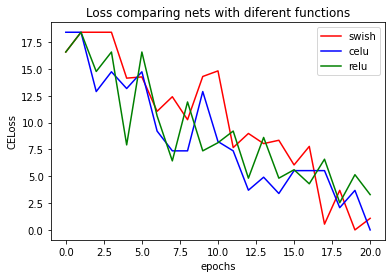

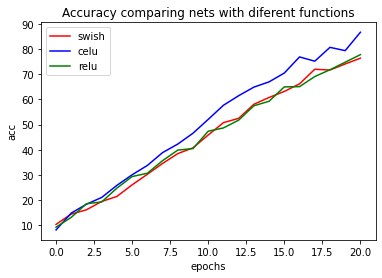

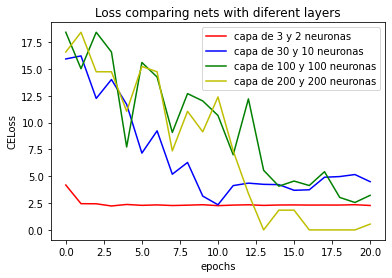

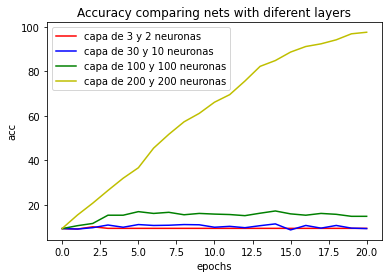

In [12]:
iterations=range(len(loss1))
loss=[loss1,loss2,loss3,loss4,loss5,loss6,loss7]
acc=[acc1,acc2,acc3,acc4,acc5,acc6,acc7]

plot_results(loss,acc)

## 4e) Opcional: Entrenando tu red con MNIST

Se usa la red para entrenar con los datos de MNIST, el dataset de imágenes de numeros escritos a mano. Se grafica la pérdida para distintas opciones de redes.

In [13]:
# Importamos MNIST desde torchvision.
from torchvision.datasets import MNIST

# Importamos una función para convertir imágenes en tensores.
from torchvision.transforms import ToTensor

# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
import random 
from random import randint

# Descarga y almacena el conjunto de prueba de MNIST.
dataset = MNIST('mnist', download= True,train=True, transform=ToTensor())
print('Cantidad total de datos:',len(dataset))

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!
Cantidad total de datos: 60000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



correctos: 60000
samples 60000
correctos: 6053
samples 60000
correctos: 60000
samples 60000
correctos: 60000
samples 60000


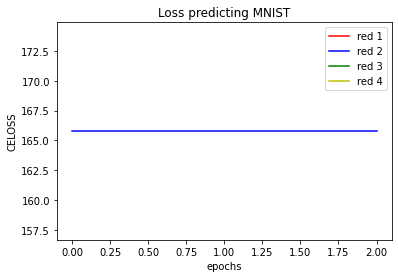

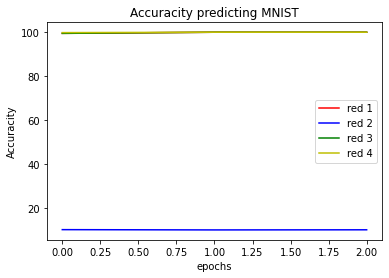

In [14]:
import numpy as np
# Tu código de carga de datos, creación de la red, 
# entrenamiento/optimización y reportes acá
class CreateDataset(Dataset):
  def __init__(self, X,Y):
    
    self.X = X
    self.Y=Y
    
  
  def __len__(self):
    return self.X.size()[0]
  
  def __getitem__(self, i):
    return self.X[i], self.Y[i]

N=len(dataset)
F=784
C=10


#T, l = dataset[idx]
#img = T.view(28,28).numpy()
#T=T.view(1,784)
dataX=np.ones((N,F),dtype=float)
dataY=np.ones((N,C),dtype=float)


for i in range(len(dataset)):
  T,l=dataset[i]
  tp=T.view(1,784)
  lp=np.ones((1,10))
  lp[0][l]=1
  dataX[i]=tp
  dataY[i]=lp

dataX=torch.from_numpy(dataX)
dataY=torch.from_numpy(dataY)

dataX=dataX.float()
dataY=dataY.float()
data=CreateDataset(dataX,dataY)

l_h=[32,16]
l_a=[relu,relu]
red1=FFNN(F,l_h,l_a,C)
loss1, acc1 = entrenar_FFNN(red1, data, optimizer, 2,10)
iterations=range(len(loss1))


l_h=[32,16]
l_a=[swish,swish]
red2=FFNN(F,l_h,l_a,C,[10,10])
loss2, acc2 = entrenar_FFNN(red2, data, optimizer, 2,10)



l_h=[32,16]
l_a=[celu,celu]
red3=FFNN(F,l_h,l_a,C,[10,10])
loss3, acc3= entrenar_FFNN(red3, data, optimizer, 2,10)

l_h=[32,16,8]
l_a=[swish,swish,relu]
red4=FFNN(F,l_h,l_a,C,[10,10])
loss4, acc4 = entrenar_FFNN(red4, data, optimizer, 2,10)

f6 = plt.figure(6)
ax6 = f6.add_subplot(111)
ax6.set_title("Loss predicting MNIST")    
ax6.set_xlabel('epochs')
ax6.set_ylabel('CELOSS')
ax6.plot(loss1, c='r',label="red 1")
ax6.plot(loss2, c='b',label="red 2")
ax6.plot(loss3, c='g',label="red 3")
ax6.plot(loss4, c='y',label="red 4")
plt.legend()
f6.show()

f7 = plt.figure(4)
ax7 = f7.add_subplot(111)
ax7.set_title("Accuracity predicting MNIST")    
ax7.set_xlabel('epochs')
ax7.set_ylabel('Accuracity')
ax7.plot(acc1, c='r',label="red 1")
ax7.plot(acc2, c='b',label="red 2")
ax7.plot(acc3, c='g',label="red 3")
ax7.plot(acc4, c='y',label="red 4")
plt.legend()
f7.show()